# Importation des librairies

In [534]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense
from tensorflow.python.keras.optimizer_v2 import adam
import numpy as np


# Préparation des données

## a) Chargement du dataset et affichage de quelques lignes

In [535]:
# import seaborn as sns

# # Load the Air Passengers dataset
# dataset = sns.load_dataset("flights")
# passengers = dataset['passengers'].values.astype(float)
dataset=pd.read_csv('AirPassengers.csv')



In [536]:
dataset.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [537]:
dataset.shape

(144, 2)

In [538]:
dataset.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [539]:
len(dataset)

144

In [540]:
dataset.dtypes

Month          object
#Passengers     int64
dtype: object

In [541]:
dataset.columns = ['Date', 'passengers']
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m')
dataset = dataset.set_index('Date')
dataset.head()

,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [542]:
dataset.dtypes

passengers    int64
dtype: object

## (b) Traçons la série temporelle pour visualiser le nombre de passagers aériens au fil du temps.


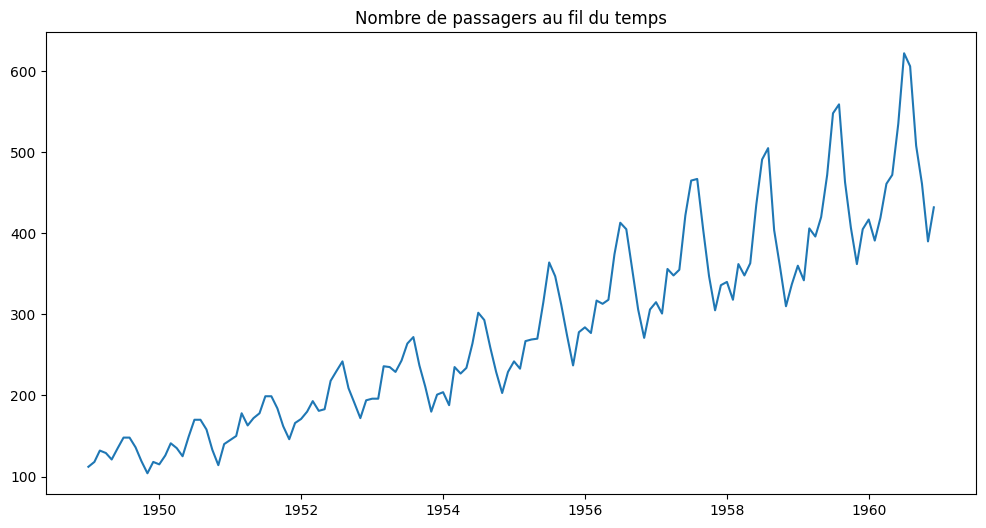

In [543]:
plt.figure(figsize=(12, 6))
plt.plot(dataset)
plt.title("Nombre de passagers au fil du temps")
plt.show()

## (c) Normalisons les données pour les préparer à l’entraînement.

In [544]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation des données entre 0 et 1
scaler = MinMaxScaler()
dataset['passengers'] = scaler.fit_transform(dataset['passengers'].values.reshape(-1, 1))


# 2. Construction du modèle LSTM

## (a) Réorganisons les données pour qu’elles soient adaptées à un problèmede prédiction de  séries temporelles : utilisons les valeurs des 12 mois précédents pour prédire la valeur du mois suivant.

In [545]:
import numpy as np

# Définissez la longueur de la séquence (12 mois)
sequence_length = 12

# Fonction pour créer les séquences
def create_sequences(data, sequence_length):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        Y.append(data[i+sequence_length])
    return np.array(X), np.array(Y)

# Appliquez la fonction aux données "passengers"
X, Y = create_sequences(dataset['passengers'].values, sequence_length)



## (b) Divisons les données en ensembles d’entraînement et de test

In [546]:
# Définissez la taille de l'ensemble d'entraînement (par exemple, 80%)
train_size = int(len(X) * 0.8)

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])


# Remodelage des données pour ajouter un pas de temps
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


## (c) Construisons un modèle LSTM avec Keras ayant les caractéristiques suivantes:
• Une couche LSTM avec 50 unités et une fonction d’activation
’relu’.
• Une couche Dense pour la prédiction.


In [547]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))


## (d) Compilons et entraînons le modèle en utilisant l’erreur quadratique moyenne (mean squared error) comme fonction de perte.

In [574]:
# Compilez le modèle avec la perte MSE (Mean Squared Error)
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)


Train on 105 samples
Epoch 1/100
105/105 - 3s - loss: 0.0446
Epoch 2/100
105/105 - 1s - loss: 0.0075
Epoch 3/100
105/105 - 1s - loss: 0.0075
Epoch 4/100
105/105 - 1s - loss: 0.0063
Epoch 5/100
105/105 - 1s - loss: 0.0062
Epoch 6/100
105/105 - 1s - loss: 0.0059
Epoch 7/100
105/105 - 1s - loss: 0.0058
Epoch 8/100
105/105 - 1s - loss: 0.0052
Epoch 9/100
105/105 - 1s - loss: 0.0062
Epoch 10/100
105/105 - 1s - loss: 0.0054
Epoch 11/100
105/105 - 1s - loss: 0.0049
Epoch 12/100
105/105 - 1s - loss: 0.0049
Epoch 13/100
105/105 - 1s - loss: 0.0055
Epoch 14/100
105/105 - 1s - loss: 0.0043
Epoch 15/100
105/105 - 1s - loss: 0.0040
Epoch 16/100
105/105 - 1s - loss: 0.0047
Epoch 17/100
105/105 - 1s - loss: 0.0036
Epoch 18/100
105/105 - 1s - loss: 0.0035
Epoch 19/100
105/105 - 1s - loss: 0.0043
Epoch 20/100
105/105 - 1s - loss: 0.0033
Epoch 21/100
105/105 - 1s - loss: 0.0032
Epoch 22/100
105/105 - 1s - loss: 0.0036
Epoch 23/100
105/105 - 1s - loss: 0.0032
Epoch 24/100
105/105 - 1s - loss: 0.0029
Epoc

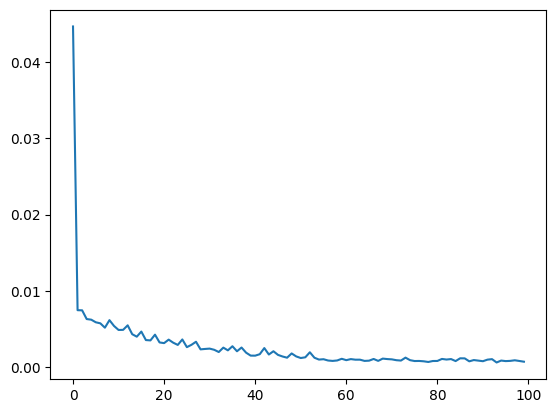

In [575]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# 3. Evaluation du modèle

## (a) Utilisons le modèle pour prédire les valeurs de l’ensemble de test

In [576]:

Predicted_values = model.predict(X_test)


c:\Users\Imam said\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\engine\training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [577]:
Predicted_values.shape

(27, 1)

## (b) Transformons les valeurs prédites en leur échelle d’origine (inverse de la normalisation).

In [578]:
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf = scaler.inverse_transform(Y_test.reshape(-1, 1))


In [579]:

predict_values = scaler.inverse_transform(Predicted_values)


## (c) Calculons et affichons l’erreur quadratique moyenne (MSE) sur l’ensemble de test.


In [580]:

mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 1374.187413392071


## (d) Traçons les valeurs réelles et les valeurs prédites du nombre de passagers aériens pour visualiser la performance du modèle

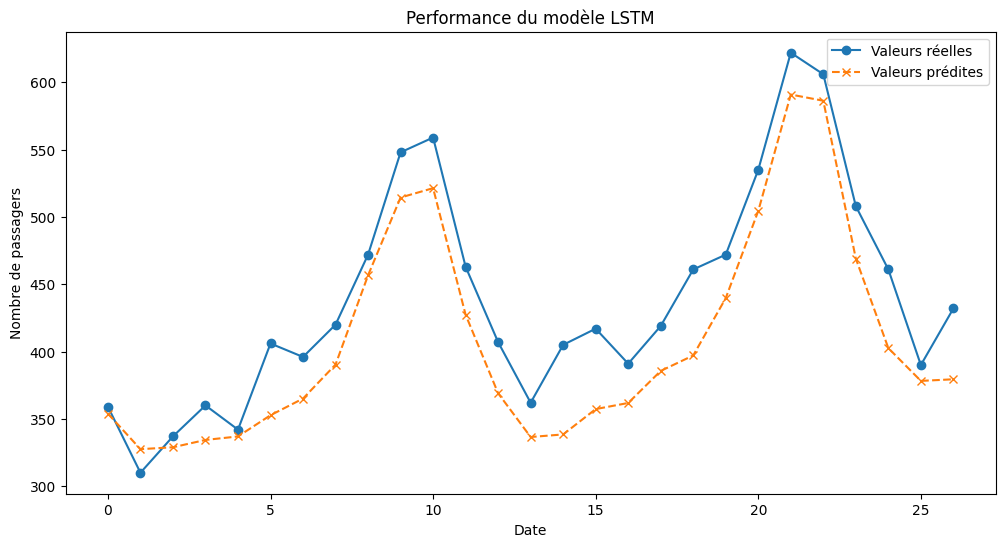

In [581]:
import matplotlib.pyplot as plt
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


# 4. Amélioration du modèle

## (a) Essayons d’améliorer les performances du modèle en ajustant différents paramètres tels que:
• Nombre d’unités LSTM.
• Nombre de couches LSTM.
• Type d’optimiseur et taux d’apprentissage

#### Essai 1
-Nombre Couche=2  et augmentation des unités LSTM de la prémière couche

In [582]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1),return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

# Compilez le modèle
model.compile(loss='mean_squared_error', optimizer='adam')


In [583]:

model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=2)

Train on 105 samples
Epoch 1/100
105/105 - 3s - loss: 0.0954
Epoch 2/100
105/105 - 0s - loss: 0.0452
Epoch 3/100
105/105 - 0s - loss: 0.0164
Epoch 4/100
105/105 - 0s - loss: 0.0112
Epoch 5/100
105/105 - 0s - loss: 0.0131
Epoch 6/100
105/105 - 0s - loss: 0.0106
Epoch 7/100
105/105 - 0s - loss: 0.0091
Epoch 8/100
105/105 - 0s - loss: 0.0082
Epoch 9/100
105/105 - 0s - loss: 0.0067
Epoch 10/100
105/105 - 0s - loss: 0.0066
Epoch 11/100
105/105 - 0s - loss: 0.0065
Epoch 12/100
105/105 - 0s - loss: 0.0064
Epoch 13/100
105/105 - 0s - loss: 0.0064
Epoch 14/100
105/105 - 0s - loss: 0.0063
Epoch 15/100
105/105 - 0s - loss: 0.0062
Epoch 16/100
105/105 - 0s - loss: 0.0061
Epoch 17/100
105/105 - 0s - loss: 0.0067
Epoch 18/100
105/105 - 0s - loss: 0.0065
Epoch 19/100
105/105 - 0s - loss: 0.0059
Epoch 20/100
105/105 - 0s - loss: 0.0062
Epoch 21/100
105/105 - 0s - loss: 0.0064
Epoch 22/100
105/105 - 0s - loss: 0.0058
Epoch 23/100
105/105 - 0s - loss: 0.0057
Epoch 24/100
105/105 - 0s - loss: 0.0058
Epoc

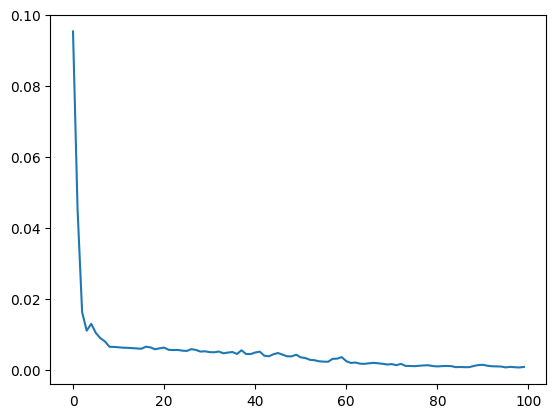

In [584]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [585]:
#Evaluation du modèle

Predicted_values = model.predict(X_test)


c:\Users\Imam said\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\engine\training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [586]:
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))

In [587]:
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))

In [588]:
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



Mean Squared Error (MSE): 1342.927387994576


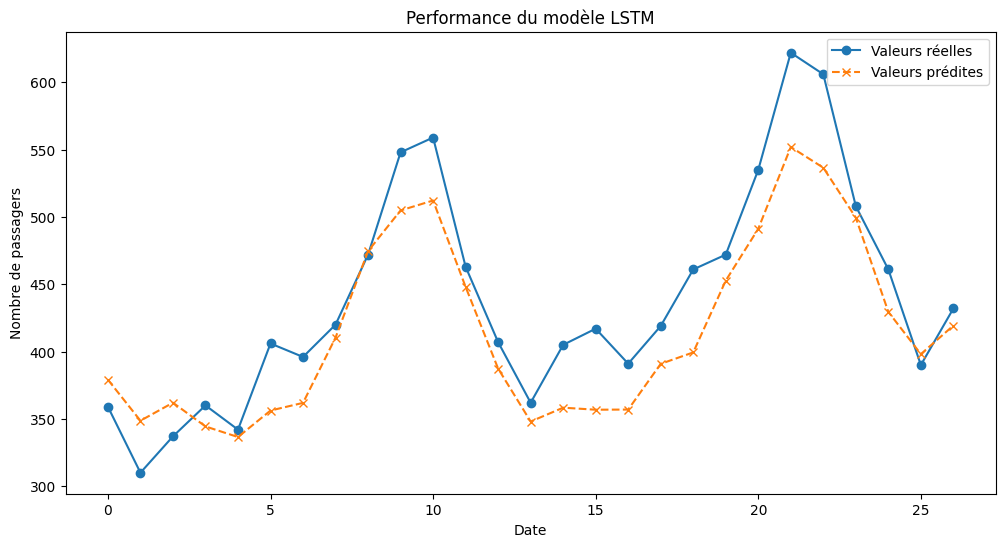

In [589]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


#### Essai 2
-Ajout de 3 couches de LSTM

In [590]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))

model.add(Dense(1))

# Compilez le modèle
model.compile(loss='mean_squared_error', optimizer='adam')


In [591]:
#entraînement
history=model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=2)

Train on 105 samples
Epoch 1/100
105/105 - 4s - loss: 0.1078
Epoch 2/100
105/105 - 0s - loss: 0.0783
Epoch 3/100
105/105 - 0s - loss: 0.0330
Epoch 4/100
105/105 - 0s - loss: 0.0211
Epoch 5/100
105/105 - 0s - loss: 0.0153
Epoch 6/100
105/105 - 0s - loss: 0.0143
Epoch 7/100
105/105 - 0s - loss: 0.0112
Epoch 8/100
105/105 - 0s - loss: 0.0087
Epoch 9/100
105/105 - 0s - loss: 0.0081
Epoch 10/100
105/105 - 0s - loss: 0.0072
Epoch 11/100
105/105 - 0s - loss: 0.0068
Epoch 12/100
105/105 - 0s - loss: 0.0072
Epoch 13/100
105/105 - 0s - loss: 0.0062
Epoch 14/100
105/105 - 0s - loss: 0.0061
Epoch 15/100
105/105 - 0s - loss: 0.0058
Epoch 16/100
105/105 - 0s - loss: 0.0059
Epoch 17/100
105/105 - 0s - loss: 0.0056
Epoch 18/100
105/105 - 0s - loss: 0.0055
Epoch 19/100
105/105 - 0s - loss: 0.0055
Epoch 20/100
105/105 - 0s - loss: 0.0054
Epoch 21/100
105/105 - 0s - loss: 0.0053
Epoch 22/100
105/105 - 0s - loss: 0.0059
Epoch 23/100
105/105 - 0s - loss: 0.0059
Epoch 24/100
105/105 - 0s - loss: 0.0051
Epoc

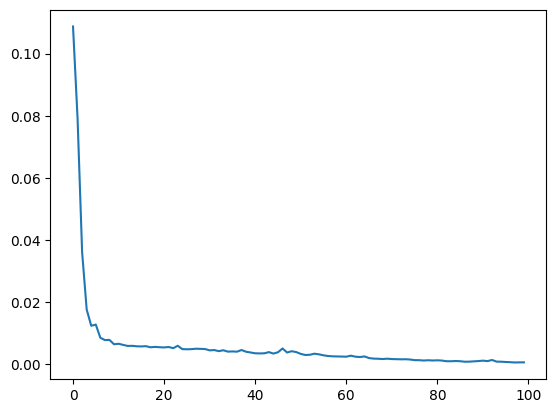

In [566]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [567]:
#Evaluation du modèle

Predicted_values = model.predict(X_test)


c:\Users\Imam said\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\engine\training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [592]:
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))

In [593]:
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))

In [570]:
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



Mean Squared Error (MSE): 2068.6401222698323


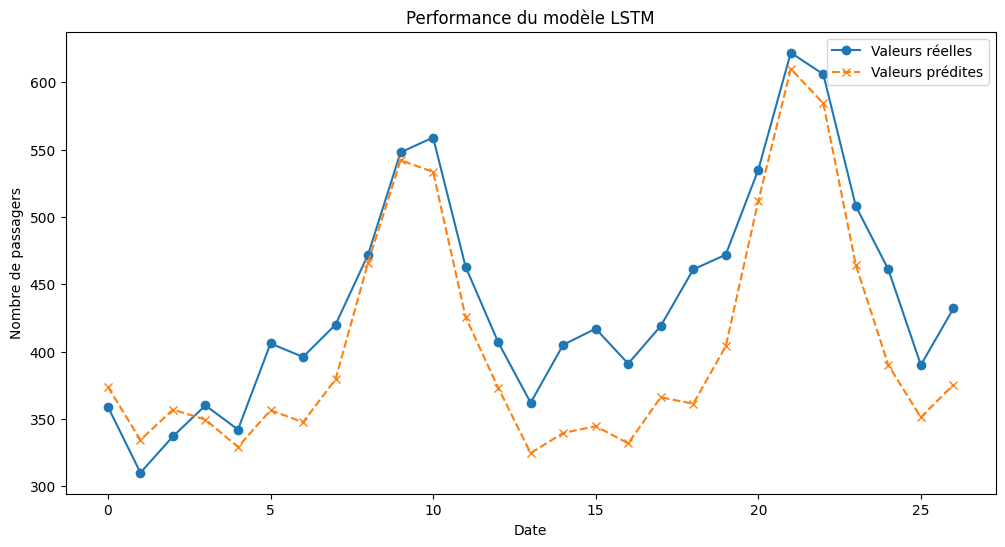

In [571]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


#### Essai 3
-Augmentation de batch_size à 16 et de learning_rate à 0,01

In [597]:
# Créez un modèle séquentiel
model = Sequential()


model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))


model.add(Dense(1))


custom_optimizer = adam.Adam(learning_rate=0.01)# 0,001
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)


model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=2)


Train on 105 samples
Epoch 1/100
105/105 - 3s - loss: 0.0542
Epoch 2/100
105/105 - 0s - loss: 0.0146
Epoch 3/100
105/105 - 0s - loss: 0.0099
Epoch 4/100
105/105 - 0s - loss: 0.0086
Epoch 5/100
105/105 - 0s - loss: 0.0066
Epoch 6/100
105/105 - 0s - loss: 0.0060
Epoch 7/100
105/105 - 0s - loss: 0.0068
Epoch 8/100
105/105 - 0s - loss: 0.0065
Epoch 9/100
105/105 - 0s - loss: 0.0058
Epoch 10/100
105/105 - 0s - loss: 0.0061
Epoch 11/100
105/105 - 0s - loss: 0.0063
Epoch 12/100
105/105 - 0s - loss: 0.0060
Epoch 13/100
105/105 - 0s - loss: 0.0063
Epoch 14/100
105/105 - 0s - loss: 0.0056
Epoch 15/100
105/105 - 0s - loss: 0.0056
Epoch 16/100
105/105 - 0s - loss: 0.0054
Epoch 17/100
105/105 - 0s - loss: 0.0057
Epoch 18/100
105/105 - 0s - loss: 0.0060
Epoch 19/100
105/105 - 0s - loss: 0.0065
Epoch 20/100
105/105 - 0s - loss: 0.0064
Epoch 21/100
105/105 - 0s - loss: 0.0058
Epoch 22/100
105/105 - 0s - loss: 0.0056
Epoch 23/100
105/105 - 0s - loss: 0.0050
Epoch 24/100
105/105 - 0s - loss: 0.0042
Epoc

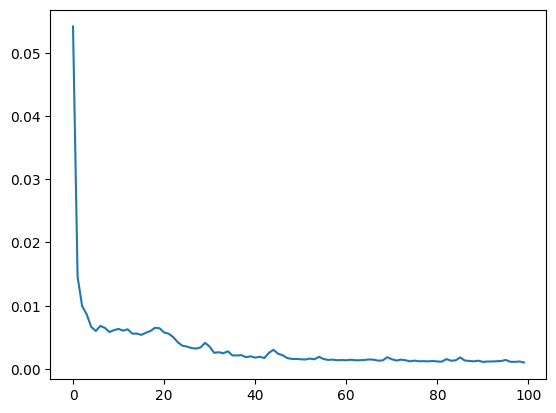

In [598]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [599]:
Predicted_values = model.predict(X_test)
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



c:\Users\Imam said\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\keras\engine\training.py:2455: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Mean Squared Error (MSE): 544.5781439358921


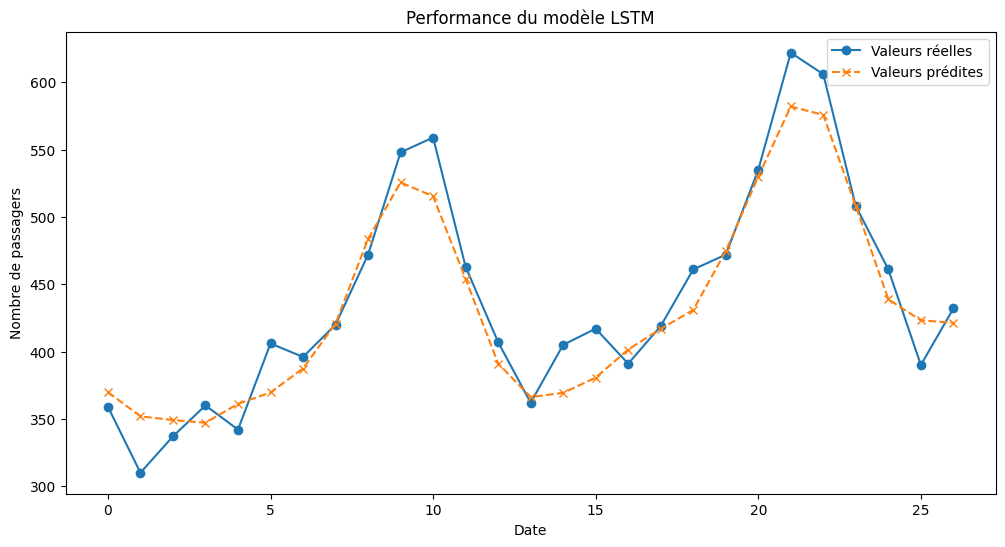

In [600]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


In [601]:
# Créez un modèle séquentiel
model = Sequential()


model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1),return_sequences=True))
#model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
# Ajoutez une couche Dense pour la prédiction
model.add(Dense(1))


custom_optimizer = adam.Adam(learning_rate=0.01)# 0,001
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)


model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)


Train on 105 samples
Epoch 1/100
105/105 - 6s - loss: 0.0195
Epoch 2/100
105/105 - 2s - loss: 0.0134
Epoch 3/100
105/105 - 2s - loss: 0.0098
Epoch 4/100
105/105 - 2s - loss: 0.0098
Epoch 5/100
105/105 - 2s - loss: 0.0116
Epoch 6/100
105/105 - 2s - loss: 0.0093
Epoch 7/100
105/105 - 2s - loss: 0.0098
Epoch 8/100
105/105 - 2s - loss: 0.0065
Epoch 9/100
105/105 - 2s - loss: 0.0064
Epoch 10/100
105/105 - 2s - loss: 0.0048
Epoch 11/100
105/105 - 2s - loss: 0.0036
Epoch 12/100
105/105 - 2s - loss: 0.0036
Epoch 13/100
105/105 - 2s - loss: 0.0033
Epoch 14/100
105/105 - 2s - loss: 0.0041
Epoch 15/100
105/105 - 2s - loss: 0.0034
Epoch 16/100
105/105 - 2s - loss: 0.0030
Epoch 17/100
105/105 - 2s - loss: 0.0028
Epoch 18/100
105/105 - 2s - loss: 0.0036
Epoch 19/100
105/105 - 2s - loss: 0.0030
Epoch 20/100
105/105 - 2s - loss: 0.0022
Epoch 21/100
105/105 - 2s - loss: 0.0023
Epoch 22/100
105/105 - 2s - loss: 0.0020
Epoch 23/100
105/105 - 2s - loss: 0.0024
Epoch 24/100
105/105 - 2s - loss: 0.0022
Epoc

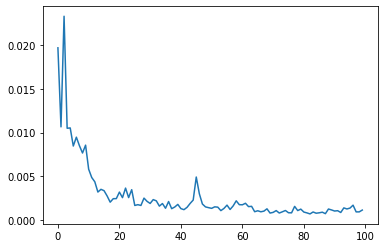

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
Predicted_values = model.predict(X_test)
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



1/1 [==============================] - 1s 586ms/step
Mean Squared Error (MSE): 1692.9366338722477


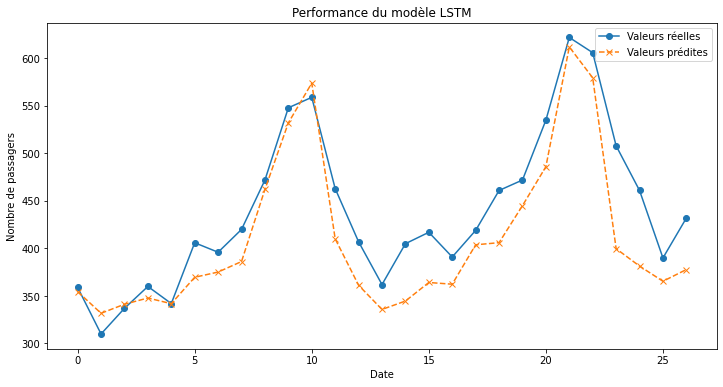

In [ ]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


#### Essai 4
-Couche=3 ,learning_rate=0,001 , batch_size=16


In [ ]:
# Créez un modèle séquentiel
model = Sequential()


model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1),return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
# Ajoutez une couche Dense pour la prédiction
model.add(Dense(1))


custom_optimizer = Adam(learning_rate=0.001)# 0,001
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)


model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=2)


Epoch 1/100
7/7 - 7s - loss: 0.1055 - 7s/epoch - 985ms/step
Epoch 2/100
7/7 - 0s - loss: 0.0652 - 159ms/epoch - 23ms/step
Epoch 3/100
7/7 - 0s - loss: 0.0223 - 157ms/epoch - 22ms/step
Epoch 4/100
7/7 - 0s - loss: 0.0213 - 168ms/epoch - 24ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0143 - 196ms/epoch - 28ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0135 - 176ms/epoch - 25ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0097 - 222ms/epoch - 32ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0081 - 199ms/epoch - 28ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0071 - 163ms/epoch - 23ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0071 - 170ms/epoch - 24ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0066 - 166ms/epoch - 24ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0065 - 150ms/epoch - 21ms/step
Epoch 13/100
7/7 - 0s - loss: 0.0058 - 159ms/epoch - 23ms/step
Epoch 14/100
7/7 - 0s - loss: 0.0058 - 157ms/epoch - 22ms/step
Epoch 15/100
7/7 - 0s - loss: 0.0056 - 167ms/epoch - 24ms/step
Epoch 16/100
7/7 - 0s - loss: 0.0062 - 167ms/epoch - 24ms/step
Epo

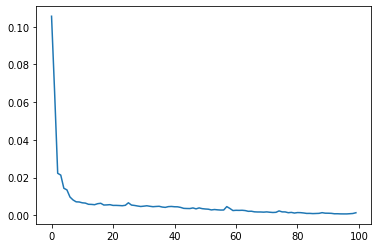

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
#Evaluation du modèle

Predicted_values = model.predict(X_test)


1/1 [==============================] - 1s 746ms/step


In [602]:
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))

In [ ]:
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))

In [ ]:
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



Mean Squared Error (MSE): 1381.203156841367


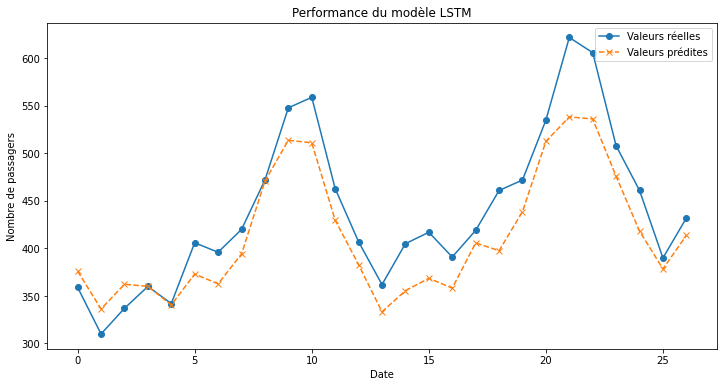

In [ ]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


#### Essai 5
- couche=3 , epochs=150 , batch_size=32 , learning_rate=0,001

In [ ]:
# Créez un modèle séquentiel
model = Sequential()


model.add(LSTM(100, activation='relu', input_shape=(sequence_length, 1),return_sequences=True))#
model.add(LSTM(50, activation='relu',return_sequences=True))
model.add(LSTM(50, activation='relu'))
#model.add(LSTM(25, activation='relu'))
# Ajoutez une couche Dense pour la prédiction
model.add(Dense(1))


custom_optimizer = Adam(learning_rate=0.001)# 0,001
model.compile(loss='mean_squared_error', optimizer=custom_optimizer)

# Entraînez le modèle en utilisant les données d'entraînement
model.fit(X_train, Y_train, epochs=150, batch_size=32, verbose=2)


Epoch 1/150
4/4 - 8s - loss: 0.1125 - 8s/epoch - 2s/step
Epoch 2/150
4/4 - 0s - loss: 0.0930 - 137ms/epoch - 34ms/step
Epoch 3/150
4/4 - 0s - loss: 0.0730 - 139ms/epoch - 35ms/step
Epoch 4/150
4/4 - 0s - loss: 0.0443 - 138ms/epoch - 35ms/step
Epoch 5/150
4/4 - 0s - loss: 0.0175 - 134ms/epoch - 33ms/step
Epoch 6/150
4/4 - 0s - loss: 0.0214 - 121ms/epoch - 30ms/step
Epoch 7/150
4/4 - 0s - loss: 0.0151 - 128ms/epoch - 32ms/step
Epoch 8/150
4/4 - 0s - loss: 0.0129 - 128ms/epoch - 32ms/step
Epoch 9/150
4/4 - 0s - loss: 0.0148 - 122ms/epoch - 31ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0119 - 130ms/epoch - 33ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0094 - 143ms/epoch - 36ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0100 - 133ms/epoch - 33ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0079 - 121ms/epoch - 30ms/step
Epoch 14/150
4/4 - 0s - loss: 0.0077 - 117ms/epoch - 29ms/step
Epoch 15/150
4/4 - 0s - loss: 0.0071 - 112ms/epoch - 28ms/step
Epoch 16/150
4/4 - 0s - loss: 0.0068 - 113ms/epoch - 28ms/step
Epoch 

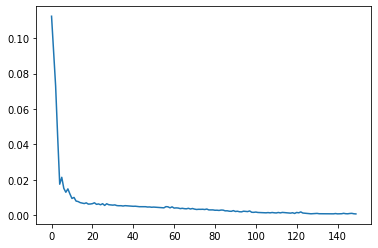

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
#Evaluation du modèle

Predicted_values = model.predict(X_test)


1/1 [==============================] - 1s 893ms/step


In [ ]:
# Transformation inverse
Y_train_tf = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_tf= scaler.inverse_transform(Y_test.reshape(-1, 1))

In [ ]:
predict_values = scaler.inverse_transform(Predicted_values.reshape(-1, 1))

In [ ]:
#mse
mse = mean_squared_error(Y_test_tf, predict_values)
print(f'Mean Squared Error (MSE): {mse}')



Mean Squared Error (MSE): 2127.713864033835


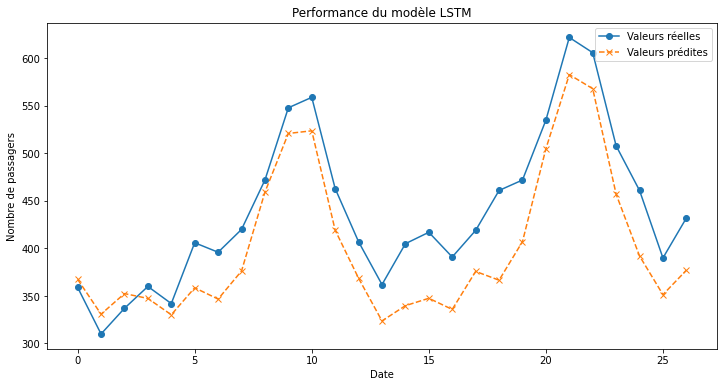

In [ ]:
# Tracez les valeurs réelles et prédites en fonction de la date
plt.figure(figsize=(12, 6))
plt.plot(Y_test_tf, label='Valeurs réelles', marker='o')
plt.plot(predict_values, label='Valeurs prédites', linestyle='--', marker='x')
plt.title('Performance du modèle LSTM')
plt.xlabel('Date')
plt.ylabel('Nombre de passagers')
plt.legend()
plt.show()


# Essai 2 a le modèle qui fonctionne le mieux